Note this notebook requires the newest version of `bycycle`, v0.1.3, which can be cloned from GitHub.

In [1]:
from bycycle.features import compute_features
from bycycle.burst import plot_burst_detect_params
from neurodsp.filt import filter_signal
import util
from config import config_dict

import h5py
import numpy as np
import pandas as pd
import os

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Make directory for saving figures
if not os.path.exists('figs/s5'):
    os.makedirs('figs/s5')

# Load shanks and choose recordings

In [3]:
# Get info about these recordings
df_stats = pd.read_csv(config_dict['processed_path'] + 'df_shanks_stats.csv', index_col=0)
df_stats = df_stats[df_stats['burst_type']==0].reset_index(drop=True)
df_stats['sh'] = df_stats['sh'].astype(str)

df_plt = df_stats.groupby('rat').last().reset_index()

# Plot example burst detection for each rat
* Confirmed that this burst detection was the same, when used full signal instead of just first 2 min
        * assert np.isclose(df[df['is_burst']]['period'].sum() / df['period'].sum(), row['cycling_frac'])

/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


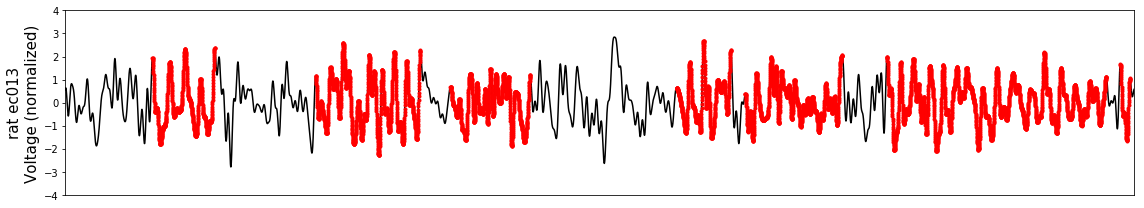

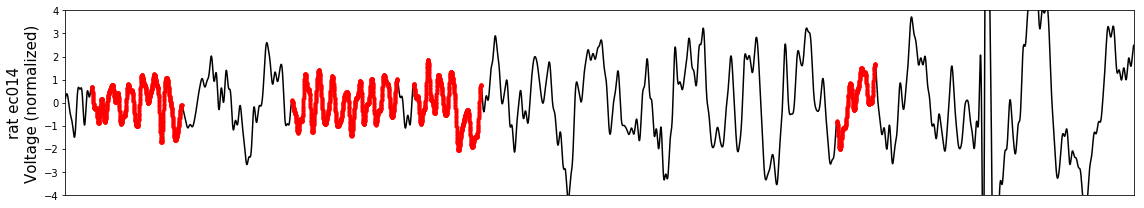

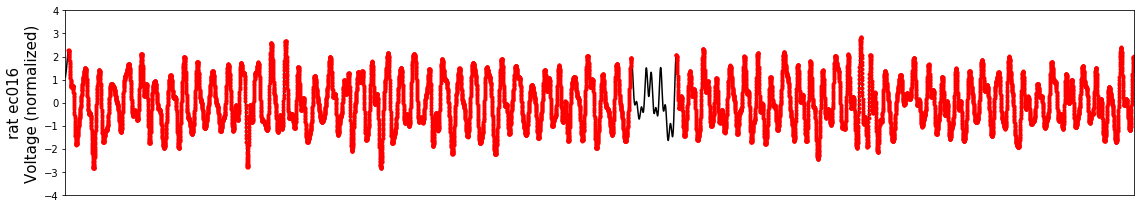

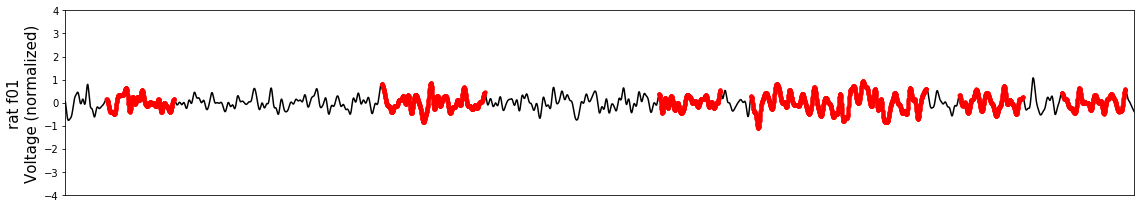

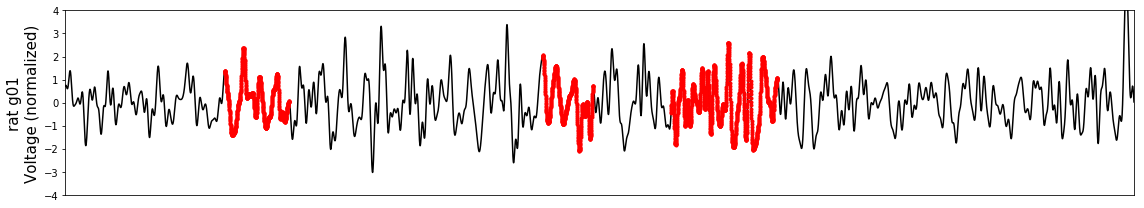

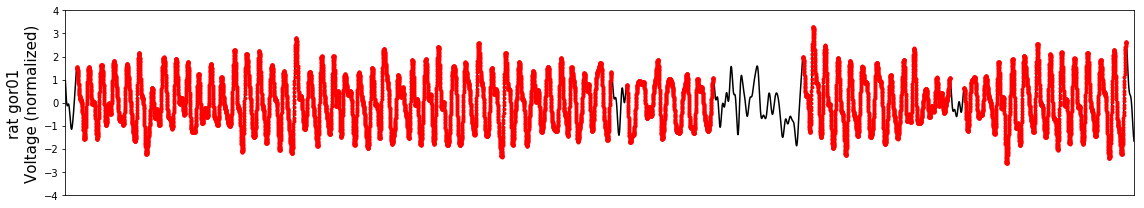

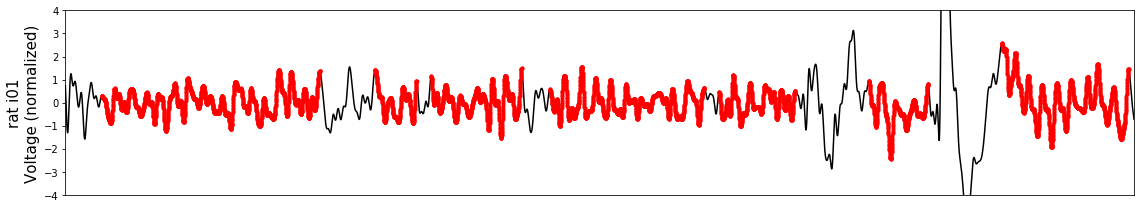

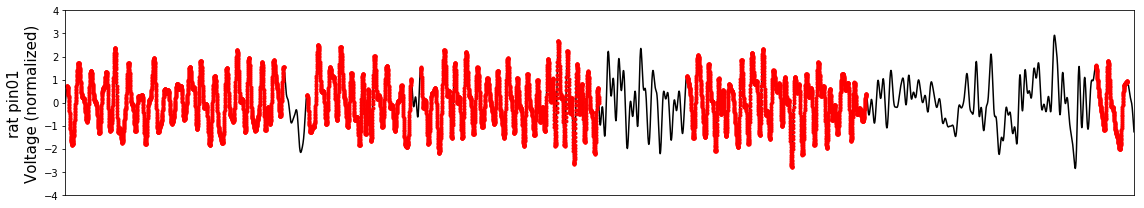

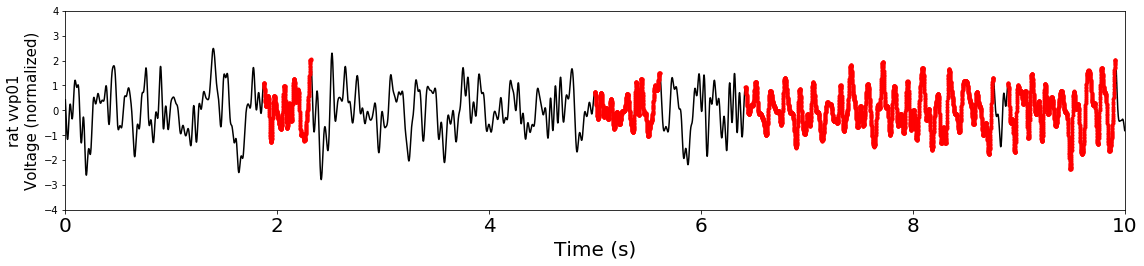

In [4]:
tlims = (30, 40)

for i, row in df_plt.iterrows():

    # Load LFP
    lfp_filename = config_dict['mat_path'] + '/' + row['rat'] + '/' + row['sess'] + '/' + row['sh'] + '/' + 'lfp' + str(row['elec']) + '.mat'
    f = h5py.File(lfp_filename)
    lfp = np.array(f['lfp']).T[0]
    
    # Only consider first 2 minute
    lfp = lfp[:int(row['Fs'] * 60 * 2)]

    # Broad bandpass filter of LFP
    lfp = filter_signal(lfp, row['Fs'], 'lowpass', config_dict['cf_low'], n_seconds=config_dict['N_seconds_low'], 
                        compute_transition_band=False, remove_edge_artifacts=False)
    lfp = filter_signal(lfp, row['Fs'], 'highpass', config_dict['cf_high'], n_seconds=config_dict['N_seconds_high'],
                        compute_transition_band=False, remove_edge_artifacts=False)
    
    # Compute shape features
    df = compute_features(lfp, row['Fs'], config_dict['f_range'],
                      center_extrema=config_dict['extrema_center'],
                      burst_detection_kwargs=config_dict['burst_kwargs_list'][0])

    # Plot burst detection parameters
    if i == len(df_plt) - 1:
        figsize = (16, 3.8)
    else:
        figsize = (16, 3)
    ax = plot_burst_detect_params(lfp, row['Fs'], df,
                                  config_dict['burst_kwargs_list'][0], tlims=tlims,
                                  plot_only_result=True, figsize=figsize)
    ax.set_ylim((-4, 4))
    ax.set_title('')
    ax.set_ylabel('rat {:s}\nVoltage (normalized)'.format(row['rat']), size=15)
    if i == len(df_plt) - 1:
        ax.set_xlabel('Time (s)', size=20)
        ax.set_xticklabels(np.linspace(0, tlims[1] - tlims[0], 6).astype(int), size=20)
    else:
        ax.set_xlabel('')
        ax.set_xticks([])
    plt.tight_layout()
    plt.savefig('figs/s5/{:s}.png'.format(row['rat']))